In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

weather = pd.read_csv('./weather_final.csv')
price = pd.read_csv('./FullPrice_final.csv')

In [2]:
weather.tail()

,Unnamed: 0,년,월,평균온도,강수량,일사량,순간최대풍속,습도
55,55,2020,8,26.40,2692.52,433.48,19.58,86.75
56,56,2020,9,20.32,1229.97,419.65,19.24,81.24
57,57,2020,10,13.72,76.72,425.55,12.71,70.97
58,58,2020,11,8.51,272.02,268.61,14.86,69.95
59,59,2020,12,0.34,79.28,249.46,13.84,66.98


In [3]:
price.tail()

,Unnamed: 0,년,월,상품소매가격,중품소매가격,전체소매가격
73,73,2021,9월,5996,4662,5329
74,74,2021,10월,5622,4492,5057
75,75,2021,11월,5411,4423,4917
76,76,2021,12월,5295,4457,4876
77,77,2021,연평균,6299,4986,5642


In [4]:
a = price[price['월']=='연평균'].index
price.drop(a, axis=0, inplace=True)

b = price[price['년']==2021].index
price.drop(b, axis=0, inplace=True)

price.drop(['Unnamed: 0'], axis=1, inplace=True)

price = price.reset_index(drop=True)
price.tail()

,년,월,상품소매가격,중품소매가격,전체소매가격
55,2020,8월,7891,6170,7030
56,2020,9월,6391,5124,5757
57,2020,10월,5707,4693,5200
58,2020,11월,5678,4534,5106
59,2020,12월,5797,4588,5192


In [5]:
#다양한 회귀 모델에 대한 예측 성능 측정
from sklearn.metrics import mean_squared_error

#RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def eval(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    print('RMSLE:{:.3f}, RMSE:{:.3f}'.format(rmsle_val, rmse_val))

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = price['전체소매가격']
X_features = weather.drop(['년', '월'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

eval(y_test, pred)

RMSLE:0.105, RMSE:462.996


- 예측 오류가 꽤 크다, 오류 값을 가장 큰 순으로 5개만 확인해본다.
- 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인

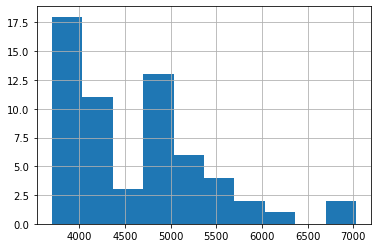

In [7]:
y_target.hist();

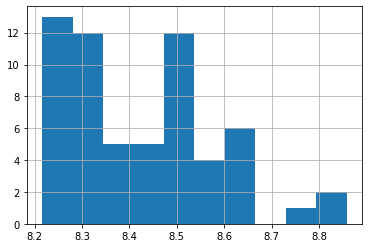

In [8]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist();

- 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상되었다.

In [9]:
#log 처리 후 다시 학습
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

eval(y_test_exp, pred_exp)

RMSLE:0.097, RMSE:441.319


- RMSLE, RMSE 오류가 줄어들었다.

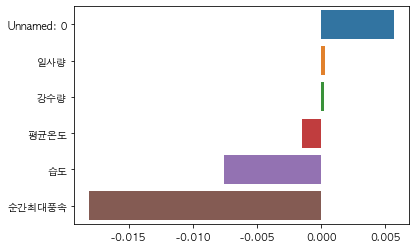

In [10]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y = coef_sort.index);

In [11]:
#개별 피처들의 원핫 인코딩
X_features_ohe = pd.get_dummies(X_features, columns = ['평균온도','강수량','일사량','순간최대풍속','습도'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
    print(model.__class__.__name__)
    eval(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in (lr_reg, ridge_reg, lasso_reg):
    get_model_predict(model, X_train, X_test, y_train, y_test)

LinearRegression
RMSLE:0.099, RMSE:469.607
Ridge
RMSLE:0.103, RMSE:489.603
Lasso
RMSLE:0.105, RMSE:500.558


- 원핫인코딩 후 선형회귀의 예측 성능을 떨어졌다.

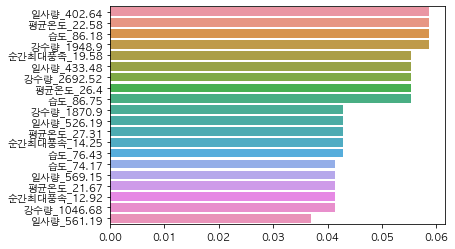

In [12]:
#원핫 인코딩을 통해 피처들의 영향도가 달라졌다.
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y = coef_sort.index);

In [13]:
#회귀트리를 이용해 회귀 예측을 수행
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

#target값은 로그 실행한 값으로, feather값은 원핫인코딩 안한 값으로 
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

RandomForestRegressor
RMSLE:0.052, RMSE:251.699
GradientBoostingRegressor
RMSLE:0.051, RMSE:244.244
XGBRegressor
RMSLE:0.070, RMSE:329.918
LGBMRegressor
RMSLE:0.132, RMSE:631.389


In [14]:
#회귀트리를 이용해 회귀 예측을 수행
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

#target값은 로그 실행한 값으로, feather값은 원핫인코딩 실행한 값으로 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

RandomForestRegressor
RMSLE:0.060, RMSE:309.767
GradientBoostingRegressor
RMSLE:0.057, RMSE:281.617
XGBRegressor
RMSLE:0.059, RMSE:263.180
LGBMRegressor
RMSLE:0.121, RMSE:566.750


In [15]:
#target값은 로그 실행한 값으로, feather값은 원핫인코딩 안한 값으로 
x_train, x_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# LinerRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print(f'LinearRegresion Score: {lin_reg.score(x_test, y_test):.3f}')

# Ridge
ridge = Ridge(alpha=0.1, random_state=0)
ridge.fit(x_train, y_train)
print(f'Ridge Score: {ridge.score(x_test, y_test):.3f}')

# Lasso
lasso = Lasso(alpha=0.1, random_state=0)
lasso.fit(x_train, y_train)
print(f'Lasso Score: {lasso.score(x_test, y_test):.3f}')

# Ridge
ridge = Ridge(alpha=0.5, random_state=0)
ridge.fit(x_train, y_train)
print(f'Ridge Score: {ridge.score(x_test, y_test):.3f}')

# Lasso
lasso = Lasso(alpha=0.5, random_state=0)
lasso.fit(x_train, y_train)
print(f'Lasso Score: {lasso.score(x_test, y_test):.3f}')

LinearRegresion Score: 0.394
Ridge Score: 0.394
Lasso Score: 0.339
Ridge Score: 0.394
Lasso Score: 0.312


In [16]:
#target값은 로그 실행한 값으로, feather값은 원핫인코딩 실행한 값으로 
x_train, x_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# LinerRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print(f'LinearRegresion Score: {lin_reg.score(x_test, y_test):.3f}')

# Ridge
ridge = Ridge(alpha=0.1, random_state=0)
ridge.fit(x_train, y_train)
print(f'Ridge Score: {ridge.score(x_test, y_test):.3f}')

# Lasso
lasso = Lasso(alpha=0.1, random_state=0)
lasso.fit(x_train, y_train)
print(f'Lasso Score: {lasso.score(x_test, y_test):.3f}')

# Ridge
ridge = Ridge(alpha=0.5, random_state=0)
ridge.fit(x_train, y_train)
print(f'Ridge Score: {ridge.score(x_test, y_test):.3f}')

# Lasso
lasso = Lasso(alpha=0.5, random_state=0)
lasso.fit(x_train, y_train)
print(f'Lasso Score: {lasso.score(x_test, y_test):.3f}')

LinearRegresion Score: 0.370
Ridge Score: 0.368
Lasso Score: 0.299
Ridge Score: 0.363
Lasso Score: 0.338


Feature Ranking:
1. feature Unnamed: 0 (0.815)
2. feature 일사량_526.19 (0.008)
3. feature 일사량_569.15 (0.008)
4. feature 평균온도_26.4 (0.006)
5. feature 순간최대풍속_13.72 (0.005)
6. feature 순간최대풍속_19.58 (0.005)
7. feature 습도_74.17 (0.005)
8. feature 강수량_2692.52 (0.005)
9. feature 습도_76.16 (0.004)
10. feature 일사량_289.98 (0.004)
11. feature 강수량_456.12 (0.004)
12. feature 강수량_1870.9 (0.004)
13. feature 평균온도_21.67 (0.004)
14. feature 일사량_402.64 (0.003)
15. feature 평균온도_7.56 (0.003)
16. feature 강수량_1244.25 (0.003)
17. feature 순간최대풍속_12.26 (0.003)
18. feature 습도_86.75 (0.003)
19. feature 강수량_1046.68 (0.003)
20. feature 일사량_447.31 (0.003)
21. feature 일사량_433.48 (0.003)
22. feature 순간최대풍속_12.9 (0.002)
23. feature 평균온도_27.31 (0.002)
24. feature 강수량_834.75 (0.002)
25. feature 순간최대풍속_12.92 (0.002)
26. feature 순간최대풍속_14.02 (0.002)
27. feature 일사량_219.3 (0.002)
28. feature 습도_70.97 (0.002)
29. feature 강수량_1948.9 (0.002)
30. feature 평균온도_15.52 (0.002)
31. feature 습도_86.18 (0.002)
32. feature 강수량_76.72 (0.002)


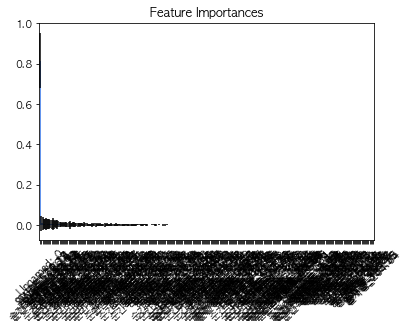

In [17]:
# 타겟 데이터에 영향을 주는 피처 중요도
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')

for f in range(x_train.shape[1]):
    print('{}. feature {} ({:.3f})'.format(f+1, x_train.columns[indices][f], importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train.shape[1]), importances[indices], color='cornflowerblue', yerr=std[indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=45)
plt.xlim([-1, x_train.shape[1]])
plt.show()